In [12]:
!pip install contractions
!pip install emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 7.5 MB/s 
     |████████████████████████████████| 287 kB 47.6 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 7.6 MB/s 
  Created wheel for emoji: filename=emoji-2.2.0-py3-none-any.whl size=234927 sha256=b297077b185110917002ee37d6fd52675f13273a710c713ef187f6d833b25f74
  Stored in directory: /root/.cache/pip/wheels/f3/e3/f2/1de1c2e3ed742e1df73e0f15d58864e50c7e64f607b548d6cf
Successfully built emoji


In [13]:
# Necessary Librabries
import pandas as pd
import numpy as np
import re
import os
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords, wordnet

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [14]:
data = pd.read_csv("subjective_reviews.csv")
data

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity,cleaned_text,tb_subjectivity,tb_polarity,pos_tags,senti_score,swn_subjectivity
0,1,5701,670062510,5,A great book for young people. It has a great...,NaN,My favorite book when I was young. I read it ...,True,children,Language.ENGLISH,A great book for young people. It has a great...,1,A great book for young people . It have a grea...,0.539394,0.271633,"[('A', 'DT'), ('great', 'JJ'), ('book', 'NN'),...",0.625,1
1,3,5021,399226907,5,Add this book to your collection,NaN,Cute and educational book to teach counting an...,True,children,Language.ENGLISH,Add this book to your collection. Cute and edu...,1,Add this book to your collection . Cute and ed...,0.525000,0.293750,"[('Add', 'VB'), ('this', 'DT'), ('book', 'NN')...",1.000,1
2,4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,Just okay.. This is one of those books you can...,0,Just okay .. This be one of those book you can...,0.500000,0.500000,"[('Just', 'RB'), ('okay', 'RB'), ('..', 'VB'),...",0.500,1
3,5,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,The paperback‚Äôs quality sucks. I hate this p...,0,The paperback‚Äôs quality suck . I hate this p...,0.797222,-0.537500,"[('The', 'DT'), ('paperback‚Äôs', 'NN'), ('qua...",-1.125,1
4,7,15810,1984806734,4,4.5 Fantastic Stars!!!,One person found this helpful,I‚Äôve seen people rate this book highly for m...,False,romance,Language.ENGLISH,4.5 Fantastic Stars!!!. I‚Äôve seen people rat...,1,4.5 Fantastic Stars ! ! ! . I‚Äôve see people ...,0.561509,0.194697,"[('4.5', 'CD'), ('Fantastic', 'JJ'), ('Stars',...",9.125,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12734,20951,4658,385376715,5,Awesome book!,NaN,I love this book. I purchased it for a baby sh...,True,children,Language.ENGLISH,Awesome book!. I love this book. I purchased i...,1,Awesome book ! . I love this book . I purchase...,0.775000,0.578125,"[('Awesome', 'JJ'), ('book', 'NN'), ('!', '.')...",1.375,1
12735,20953,6580,9387779262,4,Good,NaN,Books were smaller than I expected...but still...,True,children,Language.ENGLISH,Good. Books were smaller than I expected...but...,1,Good . Books be small than I expect ... but st...,0.656000,0.434500,"[('Good', 'JJ'), ('.', '.'), ('Books', 'NNP'),...",1.375,1
12736,20958,5670,670062510,4,My 7th graders not only love this book but the...,NaN,My 7th graders not only love this book but the...,True,children,Language.ENGLISH,My 7th graders not only love this book but the...,1,My 7th grader not only love this book but the ...,0.652222,0.031111,"[('My', 'PRP$'), ('7th', 'CD'), ('grader', 'NN...",-3.125,1
12737,20959,891,B01IW9TM5O,5,One of my favorite books ever - read almost al...,One person found this helpful,One of my favorite books ever - read almost al...,True,humor_entertainment,Language.ENGLISH,One of my favorite books ever - read almost al...,1,One of my favorite book ever - read almost all...,0.580134,0.396544,"[('One', 'CD'), ('of', 'IN'), ('my', 'PRP$'), ...",2.250,1


3527
9212


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


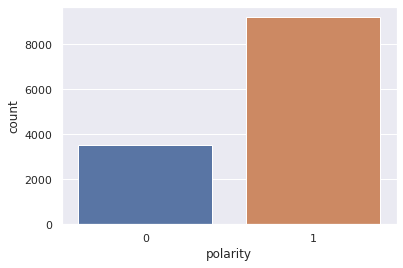

In [15]:
# View the polarity 
sb.countplot(data["polarity"])

neg = data[data['polarity'] == 0]
pos = data[data['polarity'] == 1]

print(len(neg))
print(len(pos))

In [16]:
# Balance positive and negative reviews
pos = pos.head(n=len(neg))
print(len(pos))

3527


In [17]:
# Create the new train data with the balanced datasets (POS and NEG)
train_data = pd.concat([neg, pos], ignore_index = True)
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7054 entries, 0 to 7053
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         7054 non-null   int64  
 1   Unnamed: 0.1       7054 non-null   int64  
 2   productAsin        7054 non-null   object 
 3   ratingScore        7054 non-null   int64  
 4   reviewTitle        7054 non-null   object 
 5   reviewReaction     2622 non-null   object 
 6   reviewDescription  7054 non-null   object 
 7   isVerified         7054 non-null   bool   
 8   category           7054 non-null   object 
 9   languages          7054 non-null   object 
 10  concat_review      7054 non-null   object 
 11  polarity           7054 non-null   int64  
 12  cleaned_text       7054 non-null   object 
 13  tb_subjectivity    7054 non-null   float64
 14  tb_polarity        7054 non-null   float64
 15  pos_tags           7054 non-null   object 
 16  senti_score        7054 

In [18]:
print(train_data.polarity.value_counts())

0    3527
1    3527
Name: polarity, dtype: int64


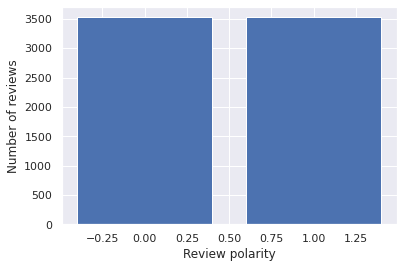

In [19]:
# Display the balanced POS and NEG reviews
sentiment_count = train_data.groupby('polarity').count()
plt.bar(sentiment_count.index.values, sentiment_count['concat_review'])
plt.xlabel('Review polarity')
plt.ylabel('Number of reviews')
plt.show()

In [20]:
# WHAT is this? LOVED. COME ON! !@#! get rid of punctuations
# Contraction words I've = I have
# removal of stop words
# removal of numbers

import contractions
import emoji
import string 
import pandas as pd
import numpy as np
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Remove emojis 
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002500-\U00002BEF"  
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)


# change to lower_case
def lower_case(review):
    
    return review.lower()

# change contraction words such sa I'm = I am, shouldn't = should not
def change_contractions(review):
    
    expanded_words = [contractions.fix(word) for word in review.split()]

    expanded_review = ' '.join(expanded_words)
    return expanded_review

# Remove Punctuations
def remove_punctuations(review):
  
  regex = re.compile('[^a-zA-Z0-9]')
  #first parameter is the replacement, second parameter is your input string
  new_review = regex.sub(' ', review);
  return new_review

# Remove numbers, we choose to remove numbers is because we find that for instance a review is descrbing about something "the 2 girls in the book is so cute"
# it could lead to 2 star review. Because we realize that, those negative reviews user, will include numbers in their reviews.
# Example: I give 2 star is because, the book is completely no link, also the words used in the book have a lot of grammatical error
# As classification is supervised learning model, it is trained by using the corpus with respect to the (sentiment category). Thus, 
# if the number 2 appear even in a positive comment, it may in the end up in the negative comment depending on how strong the number 2 in the corpus is.
# Thus, this will make the predictions go wrong. To reduce confusion for the model to learn, we decided to remove numbers
def remove_numbers(review):
    
    mapping = str.maketrans('', '', string.digits)
    new_review = review.translate(mapping)
    
    return new_review

# Remove extra whitespaces
def remove_extra_whitespace(reviews):
    return " ".join(reviews.split())

# We dont want to remove words that are from the whitelist, the reason is because it can have better meaning in our sentences
# The reason why i dont want remove one two three four etc is because, for instance if a user comment One start, this could mean it is a negative review straight away
def remove_stopwords(text):
    stopwords_list = stopwords.words('english')
    whitelist = ["not", "no", "cannot", "do", "must", "should", "would", "could"]
    words = text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]
    return " ".join(clean_words)

def get_wordnet_pos(text):
    # Map POS tag to first character lemmatize() accepts
    tags = nltk.pos_tag(text)
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tags = [tag_dict.get(tag[1][0],  wordnet.NOUN) for tag in tags]
    return tags

def lemmaSentence(reviews):
    lemmatizer = WordNetLemmatizer()
    lemma_text = ''
    tok_text = word_tokenize(reviews)
    tags = get_wordnet_pos(tok_text)
    for i in range(len(tok_text)):
        lemma_text = lemma_text + ' ' + lemmatizer.lemmatize(tok_text[i], tags[i])
    return lemma_text[1:] 

In [21]:
# Feel free to include others preprocessing tehcnique that you want, like lemmatization etc.
# -----------------------------------------------------------------------------------------
# The main function to clean text
def clean_text(data):
    
    data['concat_review'] = data['concat_review'].astype(str);
    data['concat_review'] = data['concat_review'].apply(lower_case)
    data['concat_review'] = data['concat_review'].apply(change_contractions)
    data['concat_review'] = data['concat_review'].apply(remove_emojis)
    data['concat_review'] = data['concat_review'].apply(remove_punctuations)
    data['concat_review'] = data['concat_review'].apply(remove_numbers)
    data['concat_review'] = data['concat_review'].apply(remove_stopwords)
    data['concat_review'] = data['concat_review'].apply(remove_extra_whitespace)
    data['concat_review'] = data['concat_review'].apply(lemmaSentence)
    return data

In [22]:
# Analyze some of the stopwords removal by ntlk.
stopwords_list = stopwords.words('english')

In [23]:
# Concantenate the reviewTitle with reviewDescription to provide more insights,
# helps for bette prediction, because normally reviewTitle is a summarise of their rating
# Clean the dataset remove unnecessary words
# train_data['concat_review'] = train_data['reviewTitle'] + '. ' + train_data['reviewDescription']
# train_data

In [24]:
clean_data = clean_text(train_data)
clean_data

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,concat_review,polarity,cleaned_text,tb_subjectivity,tb_polarity,pos_tags,senti_score,swn_subjectivity
0,4,21354,125030170X,2,Just okay.,NaN,This is one of those books you can read in a c...,False,children,Language.ENGLISH,okay one book read couple day story okay,0,Just okay .. This be one of those book you can...,0.500000,0.500000,"[('Just', 'RB'), ('okay', 'RB'), ('..', 'VB'),...",0.500,1
1,5,23286,63215381,1,The paperback‚Äôs quality sucks,1,I hate this paperback. Terrible quality! The p...,True,children,Language.ENGLISH,paperback quality suck hate paperback terrible...,0,The paperback‚Äôs quality suck . I hate this p...,0.797222,-0.537500,"[('The', 'DT'), ('paperback‚Äôs', 'NN'), ('qua...",-1.125,1
2,18,18756,525522131,1,The worst - would not recommend!! :(,2,This was the worst - trying too hard to be fun...,True,humor_entertainment,Language.ENGLISH,worst would not recommend bad try hard funny r...,0,The bad - would not recommend ! ! : ( . This b...,0.683758,-0.305621,"[('The', 'DT'), ('bad', 'JJ'), ('-', ':'), ('w...",-3.250,1
3,26,20458,133821666X,2,Unfortunate,115,"I, just like countless millions around the glo...",True,children,Language.ENGLISH,unfortunate like countless million around glob...,0,"Unfortunate . I , just like countless million ...",0.514042,0.161934,"[('Unfortunate', 'NNP'), ('.', '.'), ('I', 'PR...",1.750,1
4,28,21177,399255370,1,Just complaining. My kids don't need lessons i...,5,I picked this up for my 5 and 3 year old sons ...,False,children,Language.ENGLISH,complain kid do not need lesson pick year old ...,0,Just complaining . My kid do n't need lesson i...,0.557407,0.127513,"[('Just', 'RB'), ('complaining', 'NN'), ('.', ...",1.750,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7049,7986,6099,578629097,5,Perfect for the first days of school,NaN,I bought this book to read to my kinders on th...,True,children,Language.ENGLISH,perfect first day school buy book read kinders...,1,Perfect for the first day of school . I buy th...,0.577083,0.264062,"[('Perfect', 'NNP'), ('for', 'IN'), ('the', 'D...",-0.500,1
7050,7988,13953,B07GX3BR7P,5,Suspenseful,NaN,Well written. Mystery to the end. Not filled ...,True,mystery,Language.ENGLISH,suspenseful well write mystery end not fill un...,1,Suspenseful . Well write . Mystery to the end ...,0.683333,0.025000,"[('Suspenseful', 'NNP'), ('.', '.'), ('Well', ...",0.750,1
7051,7989,4543,385376715,5,Wonderful baby shower gift,NaN,It was a lovely little story. I attached it t...,True,children,Language.ENGLISH,wonderful baby shower gift lovely little story...,1,Wonderful baby shower gift . It be a lovely li...,0.709909,0.380773,"[('Wonderful', 'JJ'), ('baby', 'NN'), ('shower...",2.750,1
7052,7990,17494,399587683,5,Loved reading this book!,NaN,The book starts off hilarious and entertaining...,True,romance,Language.ENGLISH,love reading book book start hilarious enterta...,1,Loved reading this book ! . The book start off...,0.783333,0.620833,"[('Loved', 'VBN'), ('reading', 'NN'), ('this',...",0.625,1


In [41]:
# Since we are predicting polarity in the forms of -1/0/1 and is three classes so we need to use categorical cross entropy
clean_data = train_data
y = clean_data['polarity'].values
y

array([0, 0, 0, ..., 1, 1, 1])

In [26]:
# Tokenize the reviewDescription
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(text) for text in clean_data.concat_review]
tokens

[['okay', 'one', 'book', 'read', 'couple', 'day', 'story', 'okay'],
 ['paperback',
  'quality',
  'suck',
  'hate',
  'paperback',
  'terrible',
  'quality',
  'page',
  'fray',
  'rough',
  'not',
  'sure',
  'intentional',
  'not',
  'fan'],
 ['worst',
  'would',
  'not',
  'recommend',
  'bad',
  'try',
  'hard',
  'funny',
  'really',
  'half',
  'arsed',
  'predictable',
  'unnecessarily',
  'crude',
  'rather',
  'insensitive',
  'particularly',
  'regard',
  'end',
  'end',
  'inevitable',
  'give',
  'diary',
  'entry',
  'date',
  'location',
  'seem',
  'forced',
  'lack',
  'book',
  'massively',
  'overhyped',
  'definitely',
  'advise',
  'reading',
  'feel',
  'likely',
  'make',
  'feel',
  'bad'],
 ['unfortunate',
  'like',
  'countless',
  'million',
  'around',
  'globe',
  'love',
  'thing',
  'harry',
  'potter',
  'first',
  'day',
  'first',
  'book',
  'local',
  'bookstore',
  'nth',
  'read',
  'entire',
  'series',
  'well',
  'watch',
  'eight',
  'movie',
  

In [27]:
# Create your own word2vec using gensim
from gensim.models import KeyedVectors, Word2Vec

W2V_SIZE = 300 # represents how big your dimensional size of your word2vec, 
W2V_WINDOW = 2 # Window_Size refers to the how far your want this word to be 5, equal to (n-4) (n-3)....n, n(n+1)....n(n+5)word
W2V_EPOCH = 32 # Number of epochs to train the word2vec
W2V_MIN_COUNT = 2 # This mean that, if the word that occurs less than 2 times, will be drop away from the dictionary

word2vec_model = Word2Vec(size=W2V_SIZE, window=W2V_WINDOW, min_count=W2V_MIN_COUNT, workers=8)

In [28]:
word2vec_model.build_vocab(tokens)

In [29]:
word2vec_model.train(tokens, total_examples=len(tokens), epochs=32)

(6371054, 7751904)

In [30]:
word2vec_model.wv.most_similar("good") # This shows the relationship of some words shared the same similaritiy as "good", based on cosine similarity

[('great', 0.6071577668190002),
 ('excellent', 0.5434372425079346),
 ('impressed', 0.5323728322982788),
 ('decent', 0.5259321928024292),
 ('enjoyed', 0.4949115514755249),
 ('nice', 0.4764065146446228),
 ('wonderful', 0.4600028097629547),
 ('whenever', 0.43994349241256714),
 ('liked', 0.43685072660446167),
 ('favorable', 0.4359436631202698)]

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_data.concat_review)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size) # Shows the vocacbulary size of the datasets

Total words 12664


In [42]:
# Split the datasets to train/test
from sklearn.model_selection import train_test_split

random_seed = 42
X = clean_data['concat_review']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [33]:
# See what is the longest string of text
text_length =  clean_data['concat_review'].str.len()
max_len = max(text_length)
max_len  

8416

In [34]:
# Pad the sequences to make all the same == maxlength
# By right when we doing padding our sequences, the maxlen argument must be maxlen of the longest in text
# But however, the longest review in our dataset is 8416. its too long....
# Therefore, to prevent the high dimensional Word2Vec from going into RAM memory overload, we only read first 1000 word

review_len = 1000
x_train = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=review_len)
x_test = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=review_len)

In [35]:
# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]
print(embedding_matrix.shape)

(12664, 300)


In [36]:
# Creating the embedding layer based on the vocab size, Word2Vec Size, weights of the matrix as well lenth of the review
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=review_len)

In [46]:
# Creating a LSTM Model 
# Dropout is use to prevent the model from overfitting
# The activation function will be sigmoid since we are predicting on a binary classification
# loss function we will be selecting binary_crossentropy
# The reason our DENSE layer is 1 is because we r predicting either POS or NEG, thus 0 or 1 output
LSTM_model = Sequential()
LSTM_model.add(embedding_layer)
LSTM_model.add(Dropout(0.5))
LSTM_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
LSTM_model.add(Dense(1, activation='sigmoid'))
LSTM_model.compile(optimizer='adam',loss='binary_crossentropy', metrics=['accuracy'])

In [47]:
# Callbacks to incurr earlystopping
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [48]:
# I will only be choosing 5 epochs for training
# The reason is because I realize that if i trained more than 5 epochs the val_loss start to increase, so therefore is not a good sign,
# as it means the model already reached its prime of training (cannot learn anymore features from the data)
# As for the loss, it is decreasing consistently, which shows that is a good sign, that the model is not overfitting
# During fitting, the model will test again validation set, I set to 10%(y_train)
LSTM_model.fit(x_train, y_train,
                batch_size=32,
                epochs=5,
                validation_split=0.1,
                verbose=1,
                callbacks=callbacks)

Epoch 1/5
159/159 [==============================] - ETA: 0s - loss: 0.2992 - accuracy: 0.8724

159/159 [==============================] - 671s 4s/step - loss: 0.2992 - accuracy: 0.8724 - val_loss: 0.1931 - val_accuracy: 0.9168 - lr: 0.0010
Epoch 2/5
159/159 [==============================] - ETA: 0s - loss: 0.1843 - accuracy: 0.9317

159/159 [==============================] - 635s 4s/step - loss: 0.1843 - accuracy: 0.9317 - val_loss: 0.1386 - val_accuracy: 0.9398 - lr: 0.0010
Epoch 3/5
159/159 [==============================] - ETA: 0s - loss: 0.1411 - accuracy: 0.9453

159/159 [==============================] - 632s 4s/step - loss: 0.1411 - accuracy: 0.9453 - val_loss: 0.2400 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 4/5
159/159 [==============================] - ETA: 0s - loss: 0.1096 - accuracy: 0.9636

159/159 [==============================] - 625s 4s/step - loss: 0.1096 - accuracy: 0.9636 - val_loss: 0.1224 - val_accuracy: 0.9504 - lr: 0.0010
Epoch 5/5
159/159 [==============================] - ETA: 0s - loss: 0.0748 - accuracy: 0.9720

159/159 [==============================] - 634s 4s/step - loss: 0.0748 - accuracy: 0.9720 - val_loss: 0.1413 - val_accuracy: 0.9363 - lr: 0.0010


In [82]:
# help function to obtain true_pred
def get_true_pred(predictions, y_test):
    neg_count, pos_count = 0, 0
    real_neg, real_pos = 0, 0

    y_pred = []
    y_true = []

    for i, prediction in enumerate(predictions):
        if prediction < 0.5:
            neg_count += 1
            label = 0
        else:
            pos_count += 1
            label = 1

        y_pred.append(label)

        if y_test[i] == 0:
            real_neg += 1
        else:
           real_pos += 1

        y_true.append(y_test[i])

    print('Negative predictions:', neg_count)
    print('Positive predictions:', pos_count)
    print('True negative:', real_neg)
    print('True positive:', real_pos)
    
    return y_true, y_pred

In [71]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# A helper function for creating Confusion Matrix and displaying the report
def Confusion_Matrix(y_true, y_pred, model_name):
    
    cm = confusion_matrix(y_true, y_pred)
    conf_matrix=pd.DataFrame(data=cm,columns=['Predicted: 0','Predicted: 1'],
                                         index=['Actual: 0','Actual: 1'])
                                                        
    plt.figure(figsize = (10,5))
    sb.set(font_scale=1.2)
    sb.heatmap(conf_matrix, annot=True,fmt='d',cmap="YlGnBu")
    plt.title(f"Confusion Matrix for Sentiment Analysis using {model_name}")
    plt.yticks(rotation=360)
    plt.show()

    print(f"Confusion Matrix for Sentiment Analysis using {model_name}:",accuracy_score(y_true, y_pred))
    print("-"*100)
    print(f"Classification Report for Sentiment Analysis using {model_name}:\n\n",classification_report(y_true, y_pred))
    print("-"*100)

Negative predictions: 702
Positive predictions: 709
True negative: 702
True positive: 709


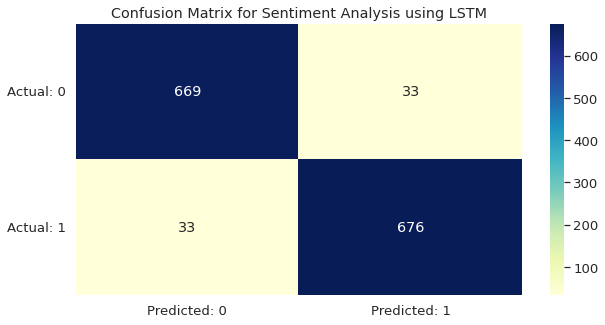

Confusion Matrix for Sentiment Analysis using LSTM: 0.9532246633593197
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using LSTM:

               precision    recall  f1-score   support

           0       0.95      0.95      0.95       702
           1       0.95      0.95      0.95       709

    accuracy                           0.95      1411
   macro avg       0.95      0.95      0.95      1411
weighted avg       0.95      0.95      0.95      1411

----------------------------------------------------------------------------------------------------


In [83]:
# Predictions and Displaying of Confusion Matrix
pred = LSTM_model.predict(x_test)
y_true, y_pred = get_true_pred(pred, y_test)
Confusion_Matrix(y_true, y_pred, 'LSTM')

In [96]:
# Testing on unseen data INPUT TEXT .... 

In [111]:
# Concatenate the data
bryson_data = pd.read_csv("test_df_Bryson.csv")
gx_data = pd.read_csv("test_df_Gx.csv")
kelvin_data = pd.read_csv("test_df_Kelvin.csv")

combine_test_data = pd.concat([bryson_data, gx_data, kelvin_data], ignore_index=True)
combine_test_data

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.1.1
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,771,22580,125030170X,1,No,NaN,Just awful!,False,children,Language.ENGLISH,-1,-1,NaN
2326,772,21540,125030170X,2,Bored,NaN,I was so bored reading this book. I switched o...,True,children,Language.ENGLISH,-1,-1,NaN
2327,773,23190,194563183X,1,Ugh!,2,"Ugh! Too wordy, predictable and shallow. I am ...",True,children,Language.ENGLISH,-1,-1,NaN
2328,774,2730,1982185821,5,A story that made me cry,One person found this helpful,I have so many fond memories of Sam from Iclar...,True,humor_entertainment,Language.ENGLISH,1,1,NaN


In [112]:
# Combine Review Title and reviewDescription to form a concatenate review
combine_test_data['concat_review'] = combine_test_data['reviewTitle'] + '. ' + combine_test_data['reviewDescription']
combine_test_data

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.1.1,concat_review
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN,The content is all messed up. I started this b...
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN,Duplicate copy.Damaged book.. Pages missing.
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN,Awful. I gave up after 38% of my Kindle. Yes w...
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN,Syrupy Overload. The book is an example of lea...
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN,"Couldn‚Äôt read it; type too small!. Beware, t..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,771,22580,125030170X,1,No,NaN,Just awful!,False,children,Language.ENGLISH,-1,-1,NaN,No. Just awful!
2326,772,21540,125030170X,2,Bored,NaN,I was so bored reading this book. I switched o...,True,children,Language.ENGLISH,-1,-1,NaN,Bored. I was so bored reading this book. I swi...
2327,773,23190,194563183X,1,Ugh!,2,"Ugh! Too wordy, predictable and shallow. I am ...",True,children,Language.ENGLISH,-1,-1,NaN,"Ugh!. Ugh! Too wordy, predictable and shallow...."
2328,774,2730,1982185821,5,A story that made me cry,One person found this helpful,I have so many fond memories of Sam from Iclar...,True,humor_entertainment,Language.ENGLISH,1,1,NaN,A story that made me cry. I have so many fond ...


In [113]:
# Credits to Jacitha's notebook
# We are going to use polarity detection so we drop all neutral reviews and convert the polarity
# positive -> 1
# negative -> 0
combine_test_data['polarity'] = combine_test_data['Annotator_1']
combine_test_data = combine_test_data.loc[combine_test_data.polarity != 0]
combine_test_data.loc[combine_test_data['polarity'] == -1, 'polarity'] = 0
print(len(combine_test_data))
combine_test_data.head()

2227


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.1.1,concat_review,polarity
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN,The content is all messed up. I started this b...,0
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN,Duplicate copy.Damaged book.. Pages missing.,0
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN,Awful. I gave up after 38% of my Kindle. Yes w...,0
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN,Syrupy Overload. The book is an example of lea...,0
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN,"Couldn‚Äôt read it; type too small!. Beware, t...",0


In [109]:
combine_test_data.polarity.value_counts()

1    1579
0     648
Name: polarity, dtype: int64

In [114]:
# Clean the dataset remove unnecessary words
combine_test_clean = clean_text(combine_test_data)
combine_test_clean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

,Unnamed: 0,Unnamed: 0.1,productAsin,ratingScore,reviewTitle,reviewReaction,reviewDescription,isVerified,category,languages,Annotator_1,Annotator_2,Unnamed: 0.1.1,concat_review,polarity
0,0,24031,1982137452,1,The content is all messed up,NaN,I started this book this week for my book club...,True,children,Language.ENGLISH,-1,-1,NaN,content mess start book week book club read wo...,0
1,1,22332,125030170X,1,Duplicate copy.Damaged book.,NaN,Pages missing.,True,children,Language.ENGLISH,-1,-1,NaN,duplicate copy damage book page miss,0
2,2,23579,63215381,1,Awful,NaN,I gave up after 38% of my Kindle. Yes we were ...,True,children,Language.ENGLISH,-1,-1,NaN,awful give kindle yes tell someone die do not ...,0
3,3,20346,60935464,1,Syrupy Overload,3,The book is an example of leading the witness.,True,children,Language.ENGLISH,-1,-1,NaN,syrupy overload book example lead witness,0
4,4,22874,1501161938,1,Couldn‚Äôt read it; type too small!,1,"Beware, the type is TINY, I mean TINY. I am 60...",True,children,Language.ENGLISH,-1,-1,NaN,read type small beware type tiny mean tiny wea...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2325,771,22580,125030170X,1,No,NaN,Just awful!,False,children,Language.ENGLISH,-1,-1,NaN,no awful,0
2326,772,21540,125030170X,2,Bored,NaN,I was so bored reading this book. I switched o...,True,children,Language.ENGLISH,-1,-1,NaN,bore bore read book switch end first page,0
2327,773,23190,194563183X,1,Ugh!,2,"Ugh! Too wordy, predictable and shallow. I am ...",True,children,Language.ENGLISH,-1,-1,NaN,ugh ugh wordy predictable shallow go start cho...,0
2328,774,2730,1982185821,5,A story that made me cry,One person found this helpful,I have so many fond memories of Sam from Iclar...,True,humor_entertainment,Language.ENGLISH,1,1,NaN,story make cry many fond memory sam iclary sin...,1


In [115]:
# Clean the test_dataset
unseen_X_test = combine_test_clean['concat_review'].values
unseen_Y_test = combine_test_clean['polarity'].values

In [116]:
# Tokenize to make it to vector format, so that it can be used for predictions
sequences_test = tokenizer.texts_to_sequences(unseen_X_test)
unseen_X_test = pad_sequences(sequences_test, maxlen=1000)
unseen_X_test

array([[   0,    0,    0, ...,   44,    1,  273],
       [   0,    0,    0, ...,    1,   24,  223],
       [   0,    0,    0, ...,  178,  292,  493],
       ...,
       [   0,    0,    0, ...,   32,  112,   16],
       [   0,    0,    0, ...,  547,   47, 1800],
       [   0,    0,    0, ..., 1104,  368,   86]], dtype=int32)

70/70 [==============================] - 19s 269ms/step
Negative predictions: 714
Positive predictions: 1513
True negative: 648
True positive: 1579


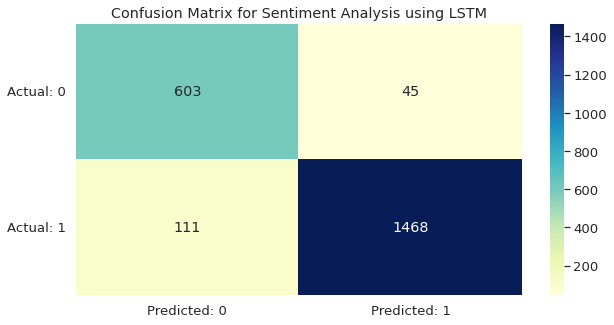

Confusion Matrix for Sentiment Analysis using LSTM: 0.9299506061966771
----------------------------------------------------------------------------------------------------
Classification Report for Sentiment Analysis using LSTM:

               precision    recall  f1-score   support

           0       0.84      0.93      0.89       648
           1       0.97      0.93      0.95      1579

    accuracy                           0.93      2227
   macro avg       0.91      0.93      0.92      2227
weighted avg       0.93      0.93      0.93      2227

----------------------------------------------------------------------------------------------------


In [117]:
pred = LSTM_model.predict(unseen_X_test)
y_true, y_pred = get_true_pred(pred, unseen_Y_test)
Confusion_Matrix(y_true, y_pred, "LSTM")

In [121]:
# Calculate the time of how fast the model predicts
import time
start_time = time.time()

len_data = len(unseen_X_test)
pred = LSTM_model.predict(unseen_X_test)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Elapsed time: {elapsed_time}")
print(f"Classification per seconds: {len_data/elapsed_time}")

70/70 [==============================] - 25s 335ms/step
Elapsed time: 25.09920835494995
Classification per seconds: 88.7278980478602


In [ ]:
## Test on self written text

In [105]:
## SAVED MODEL

# LSTM_model.save("LSTM_MODEL_subj.h5") 

In [106]:
## SAVED THE TOKENIZER
# import pickle

# with open('LSTM_tokenizer_subj.pickle', 'wb') as handle:
#     pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
## Load trained tokenizer

# import pickle
# from tensorflow import keras

# # loading
# with open('LSTM_tokenizer.pickle', 'rb') as handle:
#     LSTM_tokenizer = pickle.load(handle)

In [120]:
# from keras.models import load_model
# model = load_model('LSTM_MODEL_subj.h5')